In [35]:
import os
import sys
import shutil
from tqdm import tqdm
from typing import Dict, List, Type, Tuple
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Dataset

In [2]:
class MyDataset(Dataset):

    def __init__(self, df: pd.DataFrame):
        super().__init__()
        self._df = df

    def __len__(self):
        return self._df.shape[0]

    def __getitem__(
        self,
        index: int,
    ) -> Dict[str, torch.Tensor]:
        return dict(self._df.iloc[index])


class DataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_path: str,
        test_path: str,
        batch_size: int = 64,
        seed: int = 42,
    ):
        super().__init__()

        train_df = pd.read_pickle(train_path)
        test_df = pd.read_pickle(test_path)

        self.df = {
            "train": train_df,
            "test": test_df,
            "all": pd.concat([train_df, test_df]),
        }
        self.batch_size = batch_size

    def train_dataloader(self) -> DataLoader:
        return self._dataloader("train")

    def val_dataloader(self) -> DataLoader:
        return self._dataloader("test")

    def all_dataloader(self) -> DataLoader:
        return self._dataloader("all")

    def _dataloader(self, split: str) -> DataLoader:
        return DataLoader(
            MyDataset(self.df[split]),
            batch_size=self.batch_size,
            shuffle=split == "train",
            num_workers=int(os.environ.get("NUM_WORKERS", 0)),
        )

In [3]:
default_hparams = {
    "modality_names": ["img_emb", "text_emb"],
    "data_dims": {"img_emb": 2048, "text_emb": 384}, 
    "batch_size": 64,
    "num_epochs": 30,
    "hidden_dims": [256, 256, 256],
    "emb_dim": 128,
    "lr": 1e-3,
    "weight_decay": 5e-4,
}

In [4]:
datamodule = DataModule(
    train_path="data/cub/preprocessed_train.pkl",
    test_path="data/cub/preprocessed_test.pkl",
    batch_size=default_hparams["batch_size"],
)

# Model

In [5]:
class MVAE(nn.Module):
    def __init__(self,
                 n_latents):
        super(MVAE, self).__init__()
        self.image_encoder = Encoder(2048, [1024, 512, 256], n_latents, nn.Identity)
        self.image_decoder = Decoder(n_latents, [256, 512, 1024], 2048, nn.Identity)
        self.text_encoder = Encoder(384, [256, 256, 256], n_latents, nn.Identity)
        self.text_decoder = Decoder(n_latents, [256, 256, 256], 384, nn.Identity)
#         self.image_encoder = image_encoder
#         self.image_decoder = image_decoder
#         self.text_encoder = text_encoder
#         self.text_decoder = text_decoder
        self.product_of_experts = ProductOfExperts()
        self.n_latents = n_latents

    def get_representation(self, img_emb, text_emb):
        mu, logvar = self.forward_encoder(img_emb, text_emb)
        z = self.reparametrize(mu, logvar)
        return z
        
    def reparametrize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:  # return mean during inference
            return mu

    def forward(self, img_emb=None, text_emb=None):
        mu, logvar = self.forward_encoder(img_emb, text_emb)
#         print("MU: ", mu)
#         print("logvar: ", logvar)
#         print("_________________________________")
        # reparametrization trick to sample
        z = self.reparametrize(mu, logvar)
#         print("Z: ", z)
#         print("_________________________________")
        # reconstruct inputs based on that gaussian
        image_recon, text_recon = self.forward_decoder(z)
#         print("IMAGE: ", image_recon)
#         print("TEXT: ", text_recon)
#         print("_________________________________")
        return image_recon, text_recon, mu, logvar

    def forward_encoder(self, img_emb=None, text_emb=None):
        if img_emb is not None:
            batch_size = img_emb.size(0)
        else:
            batch_size = text_emb.size(0)

        use_cuda = next(self.parameters()).is_cuda  # check if CUDA
        mu, logvar = prior_expert((1, batch_size, self.n_latents),
                                  use_cuda=use_cuda)
#         print("MU 0: ", mu)
#         print("logvar 1: ", logvar)
#         print("_________________________________")
        if img_emb is not None:
            image_mu, image_logvar = self.image_encoder(img_emb)
            mu = torch.cat((mu, image_mu.unsqueeze(0)), dim=0)
            logvar = torch.cat((logvar, image_logvar.unsqueeze(0)), dim=0)
#         print("MU IMG: ", mu)
#         print("logvar IMG: ", logvar)
#         print("_________________________________")

        if text_emb is not None:
            text_mu, text_logvar = self.text_encoder(text_emb)
            mu = torch.cat((mu, text_mu.unsqueeze(0)), dim=0)
            logvar = torch.cat((logvar, text_logvar.unsqueeze(0)), dim=0)
        
#         print("MU BOTH: ", mu)
#         print("logvar BOTH: ", logvar)
#         print("_________________________________")

        # product of experts to combine gaussians
        mu, logvar = self.product_of_experts(mu, logvar)
#         print("MU EX: ", mu)
#         print("logvar EX: ", logvar)
#         print("_________________________________")
        return mu, logvar

    def forward_decoder(self, z):
        image_recon = self.image_decoder(z)
        text_recon = self.text_decoder(z)
        return image_recon, text_recon


class Swish(nn.Module):
    """https://arxiv.org/abs/1710.05941"""

    def forward(self, x):
        return x * torch.sigmoid(x)


class Encoder(nn.Module):
    """Parametrizes q(z|x)."""

    def __init__(self,
                 in_dims: int,
                 hidden_dims: int,
                 out_dim: int,
                 last_activation: Type[nn.Module]
                 ):
        super(Encoder, self).__init__()
        self.out_dim = out_dim
        self.encode = nn.Sequential(
            nn.Linear(in_dims, hidden_dims[0]),
            Swish(),
            *[
                layer
                for idx in range(len(hidden_dims) - 1)
                for layer in (nn.Linear(hidden_dims[idx], hidden_dims[idx + 1]), Swish())
            ],
            nn.Dropout(p=0.1),
            nn.Linear(hidden_dims[-1], out_dim * 2),
            last_activation(),
        )

    def forward(self, x):
        out_dim = self.out_dim
        x = self.encode(x)
        return x[:, :out_dim], x[:, out_dim:]


class Decoder(nn.Module):
    """Parametrizes p(x|z)."""

    def __init__(self,
                 in_dims: int,
                 hidden_dims: int,
                 out_dim: int,
                 last_activation: Type[nn.Module]
                 ):
        super(Decoder, self).__init__()
        self.out_dim = out_dim
        self.decode = nn.Sequential(
            nn.Linear(in_dims, hidden_dims[0]),
            Swish(),
            *[
                layer
                for idx in range(len(hidden_dims) - 1)
                for layer in (nn.Linear(hidden_dims[idx], hidden_dims[idx + 1]), Swish())
            ],
            nn.Linear(hidden_dims[-1], out_dim),
            last_activation(),
        )

    def forward(self, z):
        # the input will be a vector of size |n_latents|
        z = self.decode(z)
        # returns reconstructed image/text embedding
        return z  # NOTE: no sigmoid here. See train.py


class ProductOfExperts(nn.Module):
    """Return parameters for product of independent experts.
    See https://arxiv.org/pdf/1410.7827.pdf for equations.

    @param mu: M x D for M experts
    @param logvar: M x D for M experts
    """

    def forward(self, mu, logvar, eps=1e-8):
        var = torch.exp(logvar) + eps
        # precision of i-th Gaussian expert at point x
        T = 1. / var
        pd_mu = torch.sum(mu * T, dim=0) / torch.sum(T, dim=0)
        pd_var = 1. / torch.sum(T, dim=0)
        pd_logvar = torch.log(pd_var)
        return pd_mu, pd_logvar


def prior_expert(size, use_cuda=False):
    """Universal prior expert. Here we use a spherical
    Gaussian: N(0, 1).

    @param size: integer
                 dimensionality of Gaussian
    @param use_cuda: boolean [default: False]
                     cast CUDA on variables
    """
    mu = torch.zeros(size)
    logvar = torch.log(torch.ones(size))
    if use_cuda:
        mu, logvar = mu.cuda(), logvar.cuda()
    return mu, logvar


# Train/Test loop

In [18]:
def elbo_loss(recon_img_emb, img_emb, recon_text_emb, text_emb, mu, logvar,
              lambda_image=1.0, lambda_text=1.0, annealing_factor=1):
    """Bimodal ELBO loss function.

    @param recon_image: torch.Tensor
                        reconstructed image
    @param image: torch.Tensor
                  input image
    @param recon_attrs: torch.Tensor
                        reconstructed attribute probabilities
    @param attrs: torch.Tensor
                  input attributes
    @param mu: torch.Tensor
               mean of latent distribution
    @param logvar: torch.Tensor
                   log-variance of latent distribution
    @param lambda_image: float [default: 1.0]
                         weight for image BCE
    @param lambda_attrs: float [default: 1.0]
                       weight for attribute BCE
    @param annealing_factor: integer [default: 1]
                             multiplier for KL divergence term
    @return ELBO: torch.Tensor
                  evidence lower bound
    """
    image_bce, text_bce = 0, 0  # default params

    if recon_img_emb is not None and img_emb is not None:
        image_bce = F.mse_loss(recon_img_emb, img_emb) #torch.sum(binary_cross_entropy_with_logits(recon_img_emb, img_emb))

    if recon_text_emb is not None and text_emb is not None:
        text_bce = F.mse_loss(recon_text_emb, text_emb) #torch.sum(binary_cross_entropy_with_logits(recon_text_emb, text_emb))
    
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    KLD = torch.mean(
        -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1),
        dim=0,
    )
    # print("KLD :", float(KLD))
    # print("logvar: ", logvar)
    # print("mu.pow(2): ", mu.pow(2))
    # print("logvar.exp(): ", logvar.exp())
    # print("image_bce :", float(image_bce))
    # print("text_bce :", float(text_bce))
    ELBO = lambda_image * image_bce + lambda_text * text_bce + annealing_factor * KLD
    return ELBO


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(state, is_best, folder='./', filename='checkpoint.pth.tar'):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    torch.save(state, os.path.join(folder, filename))
    if is_best:
        shutil.copyfile(os.path.join(folder, filename),
                        os.path.join(folder, 'model_best.pth.tar'))


def load_checkpoint(file_path, use_cuda=False):
    checkpoint = torch.load(file_path) if use_cuda else \
        torch.load(file_path, map_location=lambda storage, location: storage)
    model = MVAE(checkpoint['n_latents'])
    model.load_state_dict(checkpoint['state_dict'])
    return model


def train(model, train_loader, optimizer, epoch, lambda_img_emb, lambda_text_emb, annealing_factor=1.0):
    model.train()
    train_loss_meter = AverageMeter()

    # NOTE: is_paired is 1 if the example is paired
    for batch_idx, sample in enumerate(train_loader):
        img_emb = sample['img_emb']
        text_emb = sample['text_emb']
        annealing_factor = 1.0

        img_emb = img_emb.cuda()
        text_emb = text_emb.cuda()
        batch_size = len(img_emb)

        # refresh the optimizer
        optimizer.zero_grad()

        train_loss = 0  # accumulate train loss here so we don't store a lot of things.

        # compute ELBO using all data (``complete")
        recon_img_emb, recon_text_emb, mu, logvar = model(img_emb, text_emb)
        train_loss += elbo_loss(recon_img_emb, img_emb, recon_text_emb, text_emb,
                                mu=mu,
                                logvar=logvar,
                                lambda_image=lambda_img_emb,
                                lambda_text=lambda_text_emb,
                                annealing_factor=annealing_factor)
        #print((recon_img_emb-img_emb).abs().sum())
        #print((recon_text_emb-text_emb).abs().sum())

        # compute ELBO using only img_emb data
        recon_img_emb, _, mu, logvar = model(img_emb=img_emb)
        train_loss += elbo_loss(recon_img_emb, img_emb, None, None,
                                mu=mu,
                                logvar=logvar,
                                lambda_image=lambda_img_emb,
                                lambda_text=lambda_text_emb,
                                annealing_factor=annealing_factor)
        

        # compute ELBO using only text data
        _, recon_text_emb, mu, logvar = model(text_emb=text_emb)
        train_loss += elbo_loss(None, None, recon_text_emb, text_emb,
                                mu=mu,
                                logvar=logvar,
                                lambda_image=lambda_img_emb,
                                lambda_text=lambda_text_emb,
                                annealing_factor=annealing_factor)
        

        # compute and take gradient step
        train_loss.backward()
        optimizer.step()
        train_loss_meter.update(train_loss.item(), batch_size)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAnnealing-Factor: {:.3f}'.format(
                epoch, batch_idx * len(img_emb), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), train_loss_meter.avg, annealing_factor))

    print('====> Epoch: {}\tLoss: {:.4f}'.format(epoch, train_loss_meter.avg))


def test(model, test_loader, optimizer, epoch, lambda_img_emb, lambda_text_emb, annealing_factor=1.0):
    model.eval()
    test_loss_meter = AverageMeter()

    pbar = tqdm(total=len(test_loader))
    for batch_idx, sample in enumerate(test_loader):
        img_emb = sample['img_emb']
        text_emb = sample['text_emb']
        img_emb = img_emb.cuda()
        text_emb = text_emb.cuda()

        batch_size = len(img_emb)

        test_loss = 0  # accumulate train loss here so we don't store a lot of things.

        # compute ELBO using all data (``complete")
        recon_img_emb, recon_text_emb, mu, logvar = model(img_emb, text_emb)
        test_loss += elbo_loss(recon_img_emb, img_emb, recon_text_emb, text_emb,
                               mu=mu,
                               logvar=logvar,
                               lambda_image=lambda_img_emb,
                               lambda_text=lambda_text_emb,
                               annealing_factor=annealing_factor)

        # compute ELBO using only img_emb data
        recon_img_emb, _, mu, logvar = model(img_emb=img_emb)
        test_loss += elbo_loss(recon_img_emb, img_emb, None, None,
                               mu=mu,
                               logvar=logvar,
                               lambda_image=lambda_img_emb,
                               lambda_text=lambda_text_emb,
                               annealing_factor=annealing_factor)

        # compute ELBO using only text data
        _, recon_text_emb, mu, logvar = model(text_emb=text_emb)
        test_loss += elbo_loss(None, None, recon_text_emb, text_emb,
                               mu=mu,
                               logvar=logvar,
                               lambda_image=lambda_img_emb,
                               lambda_text=lambda_text_emb,
                               annealing_factor=annealing_factor)
        test_loss_meter.update(test_loss.item(), batch_size)
        pbar.update()

    pbar.close()
    print('====> Test Loss: {:.4f}'.format(test_loss_meter.avg))
    return test_loss_meter.avg

In [19]:
def training_loop(model, datamodule, optimizer, epochs, lambda_img_emb, lambda_text_emb):
    best_loss = None
    is_best = True
    train_loader = datamodule.train_dataloader()
    test_loader = datamodule.val_dataloader()
    for epoch in range(1, epochs + 1):
        train(model, train_loader, optimizer, epoch, lambda_img_emb, lambda_text_emb)
        loss      = test(model, test_loader, optimizer, epoch, lambda_img_emb, lambda_text_emb)
        if best_loss is None:
            best_loss = loss
        else:
            is_best = loss < best_loss
            best_loss = min(loss, best_loss)
        # save the best model and current model
        save_checkpoint({
            'state_dict': model.state_dict(),
            'best_loss': best_loss,
            'n_latents': 128,
            'optimizer' : optimizer.state_dict(),
        }, is_best, folder='./trained_models')

In [20]:
# image_encoder = Encoder(2048, [1024, 512, 256], 128, nn.Identity)
# image_decoder = Decoder(128, [256, 512, 1024], 2048, nn.Identity)
# text_encoder = Encoder(384, [256, 256, 256], 128, nn.Identity)
# text_decoder = Decoder(128, [256, 256, 256], 384, nn.Identity)
model = MVAE(128).cuda()

In [21]:
optimizer = torch.optim.AdamW(
            params=model.parameters(),
            lr=1e-3,
            weight_decay=5e-4,
        )

training_loop(model, datamodule, optimizer, 3, 1.0, 1.0)

Train Epoch: 1 [0/59900 (0%)]	Loss: 52.380993	Annealing-Factor: 1.000
Train Epoch: 1 [6400/59900 (11%)]	Loss: 5.093155	Annealing-Factor: 1.000
Train Epoch: 1 [12800/59900 (21%)]	Loss: 2.560182	Annealing-Factor: 1.000
Train Epoch: 1 [19200/59900 (32%)]	Loss: 1.710244	Annealing-Factor: 1.000
Train Epoch: 1 [25600/59900 (43%)]	Loss: 1.284216	Annealing-Factor: 1.000
Train Epoch: 1 [32000/59900 (53%)]	Loss: 1.028259	Annealing-Factor: 1.000
Train Epoch: 1 [38400/59900 (64%)]	Loss: 0.857475	Annealing-Factor: 1.000
Train Epoch: 1 [44800/59900 (75%)]	Loss: 0.735419	Annealing-Factor: 1.000
Train Epoch: 1 [51200/59900 (85%)]	Loss: 0.643839	Annealing-Factor: 1.000
Train Epoch: 1 [57600/59900 (96%)]	Loss: 0.572586	Annealing-Factor: 1.000
====> Epoch: 1	Loss: 0.5513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 905/905 [00:03<00:00, 231.47it/s]


====> Test Loss: 0.0019
Train Epoch: 2 [0/59900 (0%)]	Loss: 0.001835	Annealing-Factor: 1.000
Train Epoch: 2 [6400/59900 (11%)]	Loss: 0.001852	Annealing-Factor: 1.000
Train Epoch: 2 [12800/59900 (21%)]	Loss: 0.001854	Annealing-Factor: 1.000
Train Epoch: 2 [19200/59900 (32%)]	Loss: 0.001854	Annealing-Factor: 1.000
Train Epoch: 2 [25600/59900 (43%)]	Loss: 0.001854	Annealing-Factor: 1.000
Train Epoch: 2 [32000/59900 (53%)]	Loss: 0.001858	Annealing-Factor: 1.000
Train Epoch: 2 [38400/59900 (64%)]	Loss: 0.001858	Annealing-Factor: 1.000
Train Epoch: 2 [44800/59900 (75%)]	Loss: 0.001858	Annealing-Factor: 1.000
Train Epoch: 2 [51200/59900 (85%)]	Loss: 0.001856	Annealing-Factor: 1.000
Train Epoch: 2 [57600/59900 (96%)]	Loss: 0.001855	Annealing-Factor: 1.000
====> Epoch: 2	Loss: 0.0019


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 905/905 [00:03<00:00, 232.40it/s]


====> Test Loss: 0.0019
Train Epoch: 3 [0/59900 (0%)]	Loss: 0.001831	Annealing-Factor: 1.000
Train Epoch: 3 [6400/59900 (11%)]	Loss: 0.001860	Annealing-Factor: 1.000
Train Epoch: 3 [12800/59900 (21%)]	Loss: 0.001855	Annealing-Factor: 1.000
Train Epoch: 3 [19200/59900 (32%)]	Loss: 0.001854	Annealing-Factor: 1.000
Train Epoch: 3 [25600/59900 (43%)]	Loss: 0.001856	Annealing-Factor: 1.000
Train Epoch: 3 [32000/59900 (53%)]	Loss: 0.001855	Annealing-Factor: 1.000
Train Epoch: 3 [38400/59900 (64%)]	Loss: 0.001854	Annealing-Factor: 1.000
Train Epoch: 3 [44800/59900 (75%)]	Loss: 0.001855	Annealing-Factor: 1.000
Train Epoch: 3 [51200/59900 (85%)]	Loss: 0.001854	Annealing-Factor: 1.000
Train Epoch: 3 [57600/59900 (96%)]	Loss: 0.001853	Annealing-Factor: 1.000
====> Epoch: 3	Loss: 0.0019


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 905/905 [00:03<00:00, 232.22it/s]


====> Test Loss: 0.0019


In [68]:
torch.cuda.empty_cache()

In [97]:
from datasets import load_dataset
DAYAATYREESgs = load_dataset("alkzar90/CC6204-Hackaton-Cub-Dataset")

df = datamodule.df["train"]

Found cached dataset cc6204-hackaton-cub-dataset (/home/erthax/.cache/huggingface/datasets/alkzar90___cc6204-hackaton-cub-dataset/default/0.0.0/de850c9086bff0dd6d6eab90f79346241178f65e1a016a50eec240ae9cdf2064)


  0%|          | 0/2 [00:00<?, ?it/s]

In [99]:
def get_most_similar(
    x: torch.Tensor,
    anchor: torch.Tensor,
    metric: str = "cosine",
    num_neighbors: int = 5,
) -> Tuple[np.ndarray, np.ndarray]:

    nn = NearestNeighbors(
        n_neighbors=num_neighbors + 1,
        metric=metric
    ).fit(x)

    similarities, indices = nn.kneighbors(anchor.reshape(1, -1))
    return similarities[0][1:], indices[0][1:]

In [122]:
def get_image(image_index: int, split="train", dataset="cub") -> np.ndarray:
    return np.array(DAYAATYREESgs[split][image_index]['image'])

def get_desc(df, index: int, split="train", dataset="cub") -> np.ndarray:
    text = df.iloc[[index]]['text'].values[0]
    return text

In [146]:
def visualize_most_similar(
    image_map,
    title: str,
    anchor_index: int,
    z: torch.Tensor,
    df: pd.DataFrame,
    metric: str = "l2",
    num_similar: int = 5,
) -> plt.Figure:
    fig, axs = plt.subplots(figsize=(15, 5), ncols=num_similar + 1)

    similarities, indices = get_most_similar(
        x=z,
        anchor=z[anchor_index],
        metric=metric,
        num_neighbors=num_similar,
    )
    
    image = get_image(image_map[anchor_index])
    desc = get_desc(df, anchor_index)
    axs[0].imshow(
        image
    )
    axs[0].set(title="Anchor", xticks=[], yticks=[])
    print("Anvchor i text: ", desc)

    for sim, index, ax in zip(similarities, indices, axs[1:]):
        image = get_image(image_map[int(index)])
        ax.imshow(image)
        desc = get_desc(df, index)
        print("Obrazek id i text: ", index, desc)
        ax.set(title=f"Dist: {sim:.10f}, ID: {index}", xticks=[], yticks=[])

    fig.suptitle(title)
    fig.tight_layout()

    return fig

In [147]:
@torch.no_grad()
def extract_embeddings(
    datamodule,
):
    best_model = load_checkpoint("./trained_models/model_best.pth.tar", use_cuda=True)
    best_model.cuda()
    best_model.eval()

    z = []
    for batch in datamodule.train_dataloader():
        text_emb = batch["text_emb"].cuda()
        img_emb = batch["img_emb"].cuda()
        z.append(best_model.get_representation(img_emb, text_emb))
    return torch.cat(z, dim=0).cpu()

In [155]:
z = extract_embeddings(datamodule)
print(z.size())
print(type(z))

torch.Size([59900, 128])
<class 'torch.Tensor'>


In [156]:
indexes = df.index.values
image_indexes = df['image_index'].values.tolist()
image_map = {indexes[i]: image_indexes[i] for i in range(len(indexes))}

Anvchor i text:  this bird is brown with a lighter brown crest.
Obrazek id i text:  43827 this bird has wings that are grey and has a white belly and orange bill
Obrazek id i text:  47619 this bird has wings that are black and has a white belly
Obrazek id i text:  59773 this bird is black, white and yellow in color with a black beak, and black eye rings.
Obrazek id i text:  31924 this jet black bird has a thin black beak and iridescent plumage.
Obrazek id i text:  7608 this large iridescent bird has black feathers which are slick and reflective.


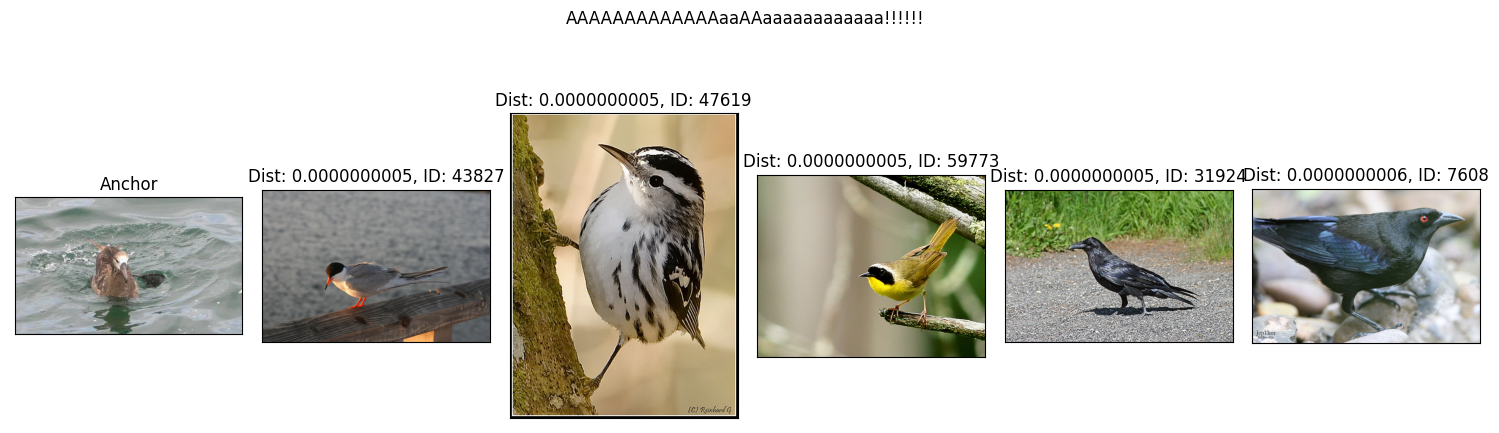

In [157]:
fig = visualize_most_similar(
    image_map,
    "AAAAAAAAAAAAAaaAAaaaaaaaaaaaa!!!!!!",
    0,
    z,
    df
)